human sounds {'euo': [0.17315565789708387, -0.056008977213231503, -0.31020678541126934, 0.14454027965375715, 0.44492665410197851, 0.90251428626118546, 0.15442378192712347, -0.56219157139381082, -0.55422565217905273, -0.39794747085590565], 'uie': [-0.23463405977074459, -0.31352627432485924, -0.31742727407164395, -0.088245880521181874, 0.18840137675693924, -0.58069409230281543, 0.18011637151669646, 0.9293475716147892, 0.89614121685626813, 0.83659596358462274], 'ieu': [-0.24555274115394887, -0.034994835610300257, 0.12572189987000648, -0.014977883300742789, -0.27031656413470984, 0.8808962011250685, 0.85034785926161405, 0.8705237682042295, 0.14828028686362771, -0.5949157762311188], 'oey': [0.49273492403418473, 0.29631245322379129, 0.11275123758046846, -0.047105135933419362, -0.24024838123854941, -0.4224398628716628, 0.18742298780706257, 0.82222686141915169, 0.69263207614574185, 0.44803249106766785], 'oiy': [0.51506137895248827, 0.065585826039699313, -0.3152405915603218, -0.24095588790181388

(-9.25, -7.5)

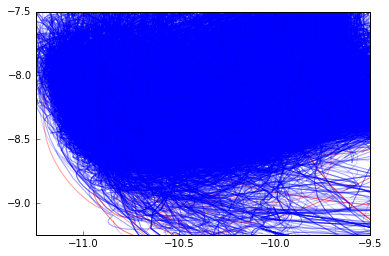

In [3]:
import sys
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
from cogsci2017.learning.supervisor import Supervisor
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

iterations = 10000

environment = CogSci2017Environment(gui=False, audio=False)


config = dict(m_mins=environment.conf.m_mins,
             m_maxs=environment.conf.m_maxs,
             s_mins=environment.conf.s_mins,
             s_maxs=environment.conf.s_maxs)

agent = Supervisor(config, model_babbling="random", n_motor_babbling=1000, explo_noise=0.05)


# Active Model Babbling
for i in range(iterations):
    if i % (iterations/10) == 0:
        print "Iteration", i
    context = environment.get_current_context()
    m = agent.produce(context)
    s = environment.update(m)
    agent.perceive(s)
    s_traj = environment.diva_traj
    if s_traj is not None:
        if i < 100:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
        else:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
            
plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

In [9]:

# Define Vowels and triplets
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
#v_a = list(np.log2([800, 1300]))

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)
                     
def check_sounds(s_traj, tol=0.25):    
    if s_traj is None:
        return "NNN"
    s1 = s_traj[0]
    s2 = s_traj[24]
    s3 = s_traj[-1]
    
    v1 = "N"
    v2 = "N"
    v3 = "N"
    
    for v in vowels.keys():
        if abs(s1[0]-vowels[v][0]) < tol and abs(s1[1]-vowels[v][1]) < tol:
            v1 = v
        if abs(s2[0]-vowels[v][0]) < tol and abs(s2[1]-vowels[v][1]) < tol:
            v2 = v
        if abs(s3[0]-vowels[v][0]) < tol and abs(s3[1]-vowels[v][1]) < tol:
            v3 = v
    
    sound = v1 + v2 + v3
    
    return sound
human_sounds = ["uyi", "ieu", "euo", "oiy", "oey", "uie"]

def compute_s_sound(sound):
    s1 = vowels[sound[0]]
    s2 = [(vowels[sound[0]][0] + vowels[sound[1]][0]) / 2., (vowels[sound[0]][1] + vowels[sound[1]][1]) / 2.]
    s3 = vowels[sound[1]]
    s4 = [(vowels[sound[1]][0] + vowels[sound[2]][0]) / 2., (vowels[sound[1]][1] + vowels[sound[2]][1]) / 2.]
    s5 = vowels[sound[2]]
    rdm = 0.05 * (2.*np.random.random((1,10))[0] - 1.)
    return list(rdm + np.array([f[0] for f in [s1, s2, s3, s4, s5]] + [f[1] for f in [s1, s2, s3, s4, s5]]))


human_sounds_traj = dict()
human_sounds_traj_std = dict()
for hs in human_sounds:
    human_sounds_traj[hs] = compute_s_sound(hs)
    human_sounds_traj_std[hs] = human_sounds_traj[hs]
    human_sounds_traj_std[hs] = [d - 8.5 for d in human_sounds_traj[hs][:5]] + [d - 10.25 for d in human_sounds_traj[hs][5:]]    

error uyi 0.62425640795


(-9.25, -7.5)

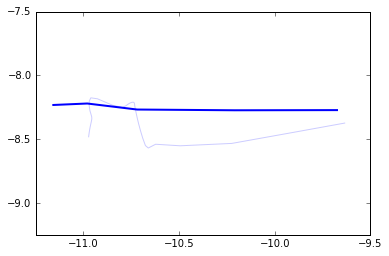

In [6]:
#for hs in human_sounds:
hs = "uyi"
m = agent.modules["mod13"].inverse(np.array(environment.get_current_context() + human_sounds_traj_std[hs]), explore=False) 
s = environment.update([0.]*21 + list(m))
s_traj = environment.diva_traj

error = np.linalg.norm(np.array(human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
print "error", hs, error


plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)    
plt.plot(- np.array(human_sounds_traj[hs][5:]), -np.array(human_sounds_traj[hs][:5]), lw=2)

plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

In [24]:
human_sounds_traj[hs], s_traj

([8.9311494496578803,
  8.8379675660237975,
  8.6318863897285816,
  8.4732113419088044,
  8.2307635654218423,
  9.7973609087394635,
  10.430814346325041,
  11.057305812497018,
  10.896536046306819,
  10.754964551377682],
 array([[  9.04106855,   9.62210646],
        [  9.09983246,   9.35828019],
        [  9.11546493,   9.01139182],
        [  9.10408789,   8.82152939],
        [  9.07405835,   8.81405016],
        [  9.03227099,   8.91151004],
        [  8.98044488,   9.0603544 ],
        [  8.91771414,   9.23666031],
        [  8.85423239,   9.3979085 ],
        [  8.79767263,   9.53612734],
        [  8.75446998,   9.64825281],
        [  8.72576484,   9.73716572],
        [  8.70869738,   9.80834132],
        [  8.69956022,   9.86676663],
        [  8.69543615,   9.91599132],
        [  8.69441233,   9.95834143],
        [  8.69531468,   9.99534565],
        [  8.69742869,  10.02805561],
        [  8.70030811,  10.05724096],
        [  8.70365351,  10.08350726],
        [  8.707221

In [28]:
agent.modules["mod13"].sm.model.imodel.fmodel.dataset.data[1]

[array([-0.01393809, -0.04525574, -0.05448173, -0.03795001,  0.08462024,
         0.21043917,  0.45      ,  0.45      ,  0.12492992,  0.56523047,
        -1.        ,  0.31371424,  0.69181534,  0.51594324,  0.46887986,
        -0.43432674,  0.42893787,  0.38621566,  0.52347367,  0.54306226]),
 array([-0.01393809, -0.04525574, -0.05448173, -0.03795001,  0.08462024,
         0.21043917,  0.45      ,  0.45      , -0.24373865,  0.67485084,
        -1.        , -1.        , -1.        , -1.        , -0.1383871 ,
         0.06640706, -0.63715011, -1.        , -0.45078775,  0.26176178]),
 array([-0.01393809, -0.04525574, -0.05448173, -0.03795001,  0.08462024,
         0.21043917,  0.45      ,  0.45      , -0.2296432 ,  0.78675033,
        -1.        , -0.45774642,  0.31919317,  0.42735395,  0.42335361,
        -0.63667033,  0.73243877,  0.36110794,  0.34480015,  0.44638361]),
 array([-0.01393809, -0.04525574, -0.05448173, -0.03795001,  0.08462024,
         0.21043917,  0.45      ,  0.45      